:# Credit Risk Analysis with Machine Learning



### Predicting the risk of client default using XGBoost, LightGBM and CatBoost



---


**Credit risk** is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans.

Minimizing the risk of default is a major concern for financial institutions. For this reason, commercial and investment banks, venture capital funds, asset management companies and insurance firms, to name a few, are increasingly relying on technology to predict which clients are more prone to not honoring their debts.

**Machine Learning** models have been helping these companies to improve the accuracy of their credit risk analysis, providing a scientific method to identify potential debtors in advance.

In this article, we will build a model to predict the risk of client default for [Nubank](https://nubank.com.br/en/about-us/), a prominent Brazilian Fintech.


## About the Data

**Nubank** is a Brazilian digital bank and one of the largest Fintechs in Latin America. It is known to be a data-driven company, taking advantage of technology to make decisions and improve services. 

The data set can be downloaded [here](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Some private information were hashed to keep the data anonymous.

Let's import the libraries we'll need for the analysis and take a first look at our data frame.

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 66 kB/s 


In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [4]:
# import data set and create a data frame
df_credit = pd.read_csv('/content/processed.csv')

In [5]:
# show first 5 rows
df_credit.head()

,Unnamed: 0,customerid,bank_branch_clients,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,referred,...,employment_status_client_Self-Employed,employment_status_client_Student,employment_status_client_Unemployed,employment_status_client_Unknown,number_of_Loans,accumlated_loan_given,accumlated_timediff,time-to-payoff,accumulated_money_won,is_late_for_firstpay
0,0,8a858e135cb22031015cbafc76964ebd,0.0,301964962.0,2.0,10000.0,13000.0,30.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,10000.0,3.667000e+12,1.300528e+15,1500.0,0.0
1,1,8a858e275c7ea5ec015c82482d7c3996,0.0,301972172.0,2.0,10000.0,13000.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,10000.0,3.668000e+12,2.840792e+15,3000.0,1.0
2,2,8a858e5b5bd99460015bdc95cd485634,0.0,301976271.0,4.0,10000.0,13000.0,30.0,1.0,0.0,...,0.0,0.0,0.0,1.0,3.0,30000.0,1.083500e+13,5.520142e+15,6000.0,1.0
3,3,8a858efd5ca70688015cabd1f1e94b55,0.0,301997763.0,2.0,10000.0,11500.0,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,10000.0,3.668000e+12,2.873995e+15,1500.0,1.0
4,4,8a858ea05a859123015a8892914d15b7,0.0,301992494.0,6.0,20000.0,24500.0,30.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5.0,70000.0,1.809800e+13,1.179669e+16,18000.0,0.0


## Data Analysis

In [6]:
# data frame shape
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

Number of rows:  4372
Number of columns:  51


We are working with a data set containing 50 features for 13698 clients. `good_bad_flag` is a binary feature and is the target variable we are trying to predict. We'll explore all features searching for outliers, treating possible missing values, and making other necessary adjustments to improve the overall quality of the model.

Let's examine the structure of the data set.

In [7]:
# data frame summary
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Unnamed: 0                                4372 non-null   int64  
 1   customerid                                4372 non-null   object 
 2   bank_branch_clients                       3277 non-null   float64
 3   systemloanid                              3277 non-null   float64
 4   loannumber                                3277 non-null   float64
 5   loanamount                                3277 non-null   float64
 6   totaldue                                  3277 non-null   float64
 7   termdays                                  3277 non-null   float64
 8   good_bad_flag                             3277 non-null   float64
 9   referred                                  3277 non-null   float64
 10  realage                             

We can see that some features have missing values. Let's take a closer look at them.

In [8]:
# percentage of missing values per feature
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

bank_name_client_First Bank                 25.045746
bank_name_client_EcoBank                    25.045746
bank_name_client_GT Bank                    25.045746
bank_name_client_Heritage Bank              25.045746
bank_name_client_Keystone Bank              25.045746
bank_name_client_Skye Bank                  25.045746
bank_name_client_Stanbic IBTC               25.045746
bank_name_client_Standard Chartered         25.045746
bank_name_client_Sterling Bank              25.045746
bank_name_client_UBA                        25.045746
bank_name_client_Union Bank                 25.045746
bank_name_client_Unity Bank                 25.045746
bank_name_client_Wema Bank                  25.045746
bank_name_client_Zenith Bank                25.045746
employment_status_client_Contract           25.045746
employment_status_client_Permanent          25.045746
employment_status_client_Retired            25.045746
employment_status_client_Self-Employed      25.045746
employment_status_client_Stu

In [9]:
df_credit = df_credit.loc[:, ~df_credit.columns.str.contains('^Unnamed')]

Due to PCA we are taking away variables longitude_gps, latitude_gps, referred, bank_account_Current, level_of_education_clients_Primary, bank_name_client_Access Bank, 	bank_name_client_Diamond Bank, 	bank_name_client_EcoBank, 	bank_name_client_FCMB, 	bank_name_client_Fidelity Bank,	bank_name_client_First Bank,
bank_name_client_Heritage Bank, bank_name_client_Keystone Bank
,	bank_name_client_Skye Bank, bank_name_client_Stanbic IBTC
,	bank_name_client_Standard Chartered, bank_name_client_Sterling Bank
,bank_name_client_UBA,	bank_name_client_Union Bank,
bank_name_client_Unity Bank, bank_name_client_Wema Bank, bank_name_client_Zenith Bank, 	employment_status_client_Contract, employment_status_client_Retired,employment_status_client_Student
,employment_status_client_Unemployed

In [10]:
df_credit = df_credit.drop(['realage', 'bank_account_Current', 'bank_name_client_EcoBank', 'bank_name_client_FCMB', 'bank_name_client_Fidelity Bank','bank_name_client_First Bank','bank_name_client_GT Bank', 'bank_name_client_Heritage Bank','bank_name_client_Keystone Bank','bank_name_client_Skye Bank','bank_name_client_Stanbic IBTC','bank_name_client_Standard Chartered', 'bank_name_client_Sterling Bank', 'bank_name_client_UBA','bank_name_client_Union Bank', 'bank_name_client_Unity Bank', 'bank_name_client_Wema Bank', 'bank_name_client_Zenith Bank','employment_status_client_Contract', 'employment_status_client_Retired', 'employment_status_client_Student', 'employment_status_client_Unemployed'], axis = 1)

Ok, now we are working with a leaner data set. Before dealing with the missing values, let's examine if there are outliers in the data set. We'll start by taking a look at some statistical details of the numerical features.

In [11]:
# show descriptive statistics
df_credit.describe()

,bank_branch_clients,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,referred,TipoInteresAhora,bank_account_Other,...,bank_name_client_Diamond Bank,employment_status_client_Permanent,employment_status_client_Self-Employed,employment_status_client_Unknown,number_of_Loans,accumlated_loan_given,accumlated_timediff,time-to-payoff,accumulated_money_won,is_late_for_firstpay
count,3277.000000,3.277000e+03,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,3277.000000,...,3277.000000,3277.000000,3277.000000,3277.000000,4367.000000,4367.000000,4.367000e+03,4.367000e+03,4367.000000,4367.000000
mean,0.010070,3.019807e+08,5.185536,17830.332621,21280.569271,29.258468,0.782118,0.137321,0.793468,0.199268,...,0.065914,0.716509,0.084529,0.150442,4.168308,68770.780856,1.603206e+13,8.608849e+15,12804.218892,0.313030
std,0.099859,1.343985e+04,3.665967,10742.059352,11929.316405,11.405342,0.412870,0.344238,0.255013,0.399511,...,0.248169,0.450761,0.278221,0.357559,3.653928,88933.675884,1.634571e+13,8.304319e+15,13982.533899,0.463779
min,0.000000,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,5000.000000,3.604000e+12,5.846000e+12,750.000000,0.000000
25%,0.000000,3.019689e+08,2.000000,10000.000000,13000.000000,30.000000,1.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,10000.000000,3.669000e+12,2.452181e+15,3000.000000,0.000000
50%,0.000000,3.019794e+08,4.000000,10000.000000,13000.000000,30.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,3.000000,30000.000000,1.082500e+13,5.340365e+15,6000.000000,0.000000
75%,0.000000,3.019934e+08,7.000000,20000.000000,24500.000000,30.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,6.000000,90000.000000,2.171550e+13,1.258960e+16,18000.000000,1.000000
max,1.000000,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,26.000000,770000.000000,1.903830e+14,4.187699e+16,96300.000000,1.000000


In [12]:
df_credit.head()

,customerid,bank_branch_clients,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,referred,TipoInteresAhora,...,bank_name_client_Diamond Bank,employment_status_client_Permanent,employment_status_client_Self-Employed,employment_status_client_Unknown,number_of_Loans,accumlated_loan_given,accumlated_timediff,time-to-payoff,accumulated_money_won,is_late_for_firstpay
0,8a858e135cb22031015cbafc76964ebd,0.0,301964962.0,2.0,10000.0,13000.0,30.0,1.0,1.0,1.00,...,0.0,0.0,0.0,1.0,1.0,10000.0,3.667000e+12,1.300528e+15,1500.0,0.0
1,8a858e275c7ea5ec015c82482d7c3996,0.0,301972172.0,2.0,10000.0,13000.0,30.0,0.0,0.0,1.00,...,0.0,1.0,0.0,0.0,1.0,10000.0,3.668000e+12,2.840792e+15,3000.0,1.0
2,8a858e5b5bd99460015bdc95cd485634,0.0,301976271.0,4.0,10000.0,13000.0,30.0,1.0,0.0,1.00,...,0.0,0.0,0.0,1.0,3.0,30000.0,1.083500e+13,5.520142e+15,6000.0,1.0
3,8a858efd5ca70688015cabd1f1e94b55,0.0,301997763.0,2.0,10000.0,11500.0,15.0,1.0,0.0,1.00,...,0.0,1.0,0.0,0.0,1.0,10000.0,3.668000e+12,2.873995e+15,1500.0,1.0
4,8a858ea05a859123015a8892914d15b7,0.0,301992494.0,6.0,20000.0,24500.0,30.0,1.0,0.0,0.75,...,0.0,1.0,0.0,0.0,5.0,70000.0,1.809800e+13,1.179669e+16,18000.0,0.0


In [17]:
df_credit = df_credit.dropna()

In [18]:
df_credit.isnull().sum()

customerid                                  0
bank_branch_clients                         0
systemloanid                                0
loannumber                                  0
loanamount                                  0
totaldue                                    0
termdays                                    0
good_bad_flag                               0
referred                                    0
TipoInteresAhora                            0
bank_account_Other                          0
bank_account_Savings                        0
level_of_education_clients_Graduate         0
level_of_education_clients_Post-Graduate    0
level_of_education_clients_Primary          0
level_of_education_clients_Secondary        0
level_of_education_clients_Unknown          0
bank_name_client_Access Bank                0
bank_name_client_Diamond Bank               0
employment_status_client_Permanent          0
employment_status_client_Self-Employed      0
employment_status_client_Unknown  

After handling the missing values, case by case, we now have a data set free of null values.

We'll now preprocess the data, converting the categorical features into numerical values. `LabelEncoder` will be used for the binary variables while `get_dummies` will be used for the other categorical variables.

## Machine Learning Models

We are experimenting with the following 3 boosting algorithms to determine which one yields better results:


*   XGBoost
*   LightGBM
*   CatBoost

Before starting with the models, let's split the data into training and test sets.

In [19]:
# feature matrix
X = df_credit.drop(['customerid','good_bad_flag', 'systemloanid'], axis=1)

# target vector
y = df_credit['good_bad_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

In [20]:
# standardize numerical variables
from imblearn.under_sampling import RandomUnderSampler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# resample
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

We're all set up to start evaluating the models. It's worth mentioning that we should consider `Precision`, `Recall` and `F1 Score` as evaluation metrics, for the following reasons:


*   **Precision** will give us the proportion of positive identifications that were indeed correct. It can be defined as:

${Precision} = \frac{True Positives}{True Positives + False Positives}$


*   **Recall** will determine the proportion of real positives that were 
correctly identified, and it can be defined as:

${Recall} = \frac{True Positives}{True Positives + False Negatives}$

*   **F1 Score** is a metric that is useful when we need to seek a balance between precision and recall. The formula is defined as:

${F_1} = 2 \times \frac{Precision \times Recall}{Precision + Recall}$


Since our objective is to minimize company loss, predicting the risk of client default, a good recall rate is desirable because we want to identify the maximum amount of clients that are indeed prone to stop paying their debts, thus, we are pursuing a small number of *False Negatives*.

Additionally, we also seek to minimize the number of False Positives because we don't want clients to be mistakenly identified as defaulters. Therefore, a good precision rate is also desirable.

However, there is always a tradeoff between precision and recall. For this article, we chose to give more emphasis to recall, using it as our evaluation metric. 

We'll use Cross-Validation to get better results. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

In [21]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

In [22]:
#evaluate the models
xgb = XGBClassifier()
lgb = LGBMClassifier()
cb = CatBoostClassifier()

model = []
recall = []

for clf in (xgb, lgb, cb):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, show=False))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

Se han truncado las últimas 5000 líneas del flujo de salida.
4:	learn: 0.6862986	total: 57.6ms	remaining: 11.5s
5:	learn: 0.6847490	total: 59.8ms	remaining: 9.91s
6:	learn: 0.6834219	total: 61.9ms	remaining: 8.78s
7:	learn: 0.6824052	total: 64.2ms	remaining: 7.96s
8:	learn: 0.6812098	total: 66.3ms	remaining: 7.3s
9:	learn: 0.6799594	total: 68.5ms	remaining: 6.78s
10:	learn: 0.6787676	total: 70.6ms	remaining: 6.34s
11:	learn: 0.6775586	total: 72.6ms	remaining: 5.98s
12:	learn: 0.6768037	total: 73.5ms	remaining: 5.58s
13:	learn: 0.6754040	total: 75.9ms	remaining: 5.34s
14:	learn: 0.6741008	total: 78.3ms	remaining: 5.14s
15:	learn: 0.6729528	total: 82.6ms	remaining: 5.08s
16:	learn: 0.6717345	total: 84.7ms	remaining: 4.9s
17:	learn: 0.6703651	total: 86.9ms	remaining: 4.74s
18:	learn: 0.6691816	total: 89ms	remaining: 4.59s
19:	learn: 0.6682527	total: 91.1ms	remaining: 4.46s
20:	learn: 0.6669940	total: 93.3ms	remaining: 4.35s
21:	learn: 0.6660445	total: 95.5ms	remaining: 4.25s
22:	learn: 0.

,Recall
XGBClassifier,0.694816
LGBMClassifier,0.588097
CatBoostClassifier,0.687357


Notice that all three models yielded similar results. We'll now tune some hyperparameters on the models to see if we can achieve higher score values. The method utilized here is `GridSearchCV`, which will search over specified parameter values for each estimator.

### XGBoost

Let's start by making some adjustments to the XGBoost estimator. XGBoost is known for being one of the most effective Machine Learning algorithms, due to its good performance on structured and tabular datasets on classification and regression predictive modeling problems. It is highly customizable and counts with a large range of hyperparameters to be tuned.

For the XGBoost model, we'll tune the following hyperparameters, according to [the official documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):


*   `n_estimators` - The number of trees in the model
*   `max_depth` - Maximum depth of a tree
*   `min_child_weight` - Minimum sum of instance weight needed in a child
*   `gamma` - Minimum loss reduction required to make a further partition on a leaf node of the tree
*   `learning_rate` - Step size shrinkage used in the update to prevents overfitting

In [23]:
# XGBoost
xgb = XGBClassifier()

# parameter to be searched
param_grid = {'n_estimators': range(0,1000,50)}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.6760299625468166 for {'n_estimators': 50}


In [24]:
# XGBoost
xgb = XGBClassifier(n_estimators=50)

# parameter to be searched
param_grid = {'max_depth': [1, 3, 5],
              'min_child_weight': [1, 3, 6]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7509363295880149 for {'max_depth': 1, 'min_child_weight': 1}


In [25]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6)

# parameter to be searched
param_grid = {'gamma': [0, 1, 5]}

# find the best parameter   
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7734082397003745 for {'gamma': 5}


In [26]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6, gamma=1)

# parameter to be searched
param_grid = {'learning_rate': [0.0001, 0.001, 0.01, 0.1]}

# find the best parameter
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7808988764044944 for {'learning_rate': 0.01}


### LightGBM

Now, turning to the LightGBM model, another tree-based learning algorithm, we are going to tune the following hyperparameters, referring to the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html):

*   `max_depth` - Maximum depth of a tree
*   `learning_rate` - Shrinkage rate
*   `num_leaves` - Max number of leaves in one tree
*   `min_data_in_leaf` - Minimal number of data in one leaf



In [27]:
# LightGBM
lbg = LGBMClassifier(silent=False)

# parameter to be searched
param_grid = {"max_depth": np.arange(5, 75, 10),
              "learning_rate" : [0.001, 0.01, 0.1],
              "num_leaves": np.arange(20, 220, 50),
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7359550561797753 for {'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 20}


In [28]:
lbg = LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=50, silent=False)

# parameter to be searched
param_grid = {'min_data_in_leaf': np.arange(100, 1000, 100)}

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(lbg, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

Best result: 0.7584269662921349 for {'min_data_in_leaf': 100}


### CatBoost

Lastly, we're going to search over hyperparameter values for CatBoost, our third gradient boosting algorithm. The following hyperparameters will be tuned, according to the [documentation](https://catboost.ai/docs/concepts/parameter-tuning.html):


*   `depth` - Depth of the tree
*   `learning_rate` - As we already know, the learning rate
*   `l2_leaf_reg` - Coefficient at the L2 regularization term of the cost function



In [29]:
# CatBoost
cb = CatBoostClassifier()

# parameter to be searched
param_grid = {'depth': [6, 8, 10],
              'learning_rate': [0.03, 0.1],
              'l2_leaf_reg': [1, 5, 10],
             }

# find the best parameter            
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(cb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')

0:	learn: 0.6891279	total: 2.42ms	remaining: 2.42s
1:	learn: 0.6860685	total: 4.55ms	remaining: 2.27s
2:	learn: 0.6829364	total: 6.72ms	remaining: 2.23s
3:	learn: 0.6798054	total: 8.79ms	remaining: 2.19s
4:	learn: 0.6765531	total: 10.9ms	remaining: 2.17s
5:	learn: 0.6732598	total: 13ms	remaining: 2.15s
6:	learn: 0.6698128	total: 15.1ms	remaining: 2.14s
7:	learn: 0.6673673	total: 17.3ms	remaining: 2.14s
8:	learn: 0.6647832	total: 19.3ms	remaining: 2.13s
9:	learn: 0.6623744	total: 21.4ms	remaining: 2.12s
10:	learn: 0.6601452	total: 23.5ms	remaining: 2.11s
11:	learn: 0.6579466	total: 25.5ms	remaining: 2.1s
12:	learn: 0.6566879	total: 26.1ms	remaining: 1.98s
13:	learn: 0.6540364	total: 28.2ms	remaining: 1.98s
14:	learn: 0.6517967	total: 30.2ms	remaining: 1.98s
15:	learn: 0.6496311	total: 32.3ms	remaining: 1.99s
16:	learn: 0.6476041	total: 34.4ms	remaining: 1.99s
17:	learn: 0.6459735	total: 36.4ms	remaining: 1.99s
18:	learn: 0.6441464	total: 38.5ms	remaining: 1.99s
19:	learn: 0.6426418	tota

After tuning some hyperparameters, all three models displayed betters results. It is worth mentioning that XGBoost presented a great score increase, while LightGBM and CatBoost saw a slight improvement.

Now, we can check how these models perform on the **test set**. To help us visualize the results, we are plotting a **confusion matrix**.

              precision    recall  f1-score   support

         0.0       0.36      0.47      0.41       178
         1.0       0.84      0.77      0.80       640

    accuracy                           0.70       818
   macro avg       0.60      0.62      0.60       818
weighted avg       0.73      0.70      0.72       818



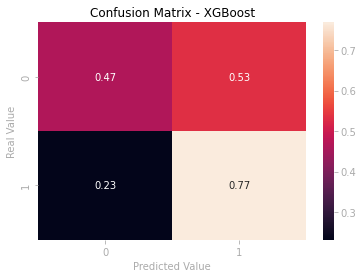

In [32]:
# final XGBoost model
xgb = XGBClassifier(n_estimators=50, max_depth=3, min_child_weight=6, gamma=1, learning_rate = 0.01)


xgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

         0.0       0.27      0.54      0.36       178
         1.0       0.82      0.60      0.69       640

    accuracy                           0.58       818
   macro avg       0.55      0.57      0.53       818
weighted avg       0.70      0.58      0.62       818



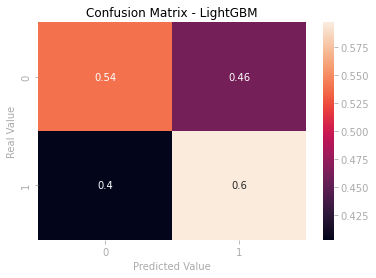

In [35]:
# final LightGBM model
lbg = LGBMClassifier(learning_rate=0.01, max_depth=5, num_leaves=50, min_data_in_leaf= 100, silent=False)
lgb.fit(X_train_rus, y_train_rus)

# prediction
X_test_lgb = scaler.transform(X_test)
y_pred_lgb = lgb.predict(X_test_lgb)

# classification report
print(classification_report(y_test, y_pred_lgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_lgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - LightGBM')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

              precision    recall  f1-score   support

         0.0       0.29      0.55      0.38       178
         1.0       0.83      0.62      0.71       640

    accuracy                           0.61       818
   macro avg       0.56      0.59      0.54       818
weighted avg       0.71      0.61      0.64       818



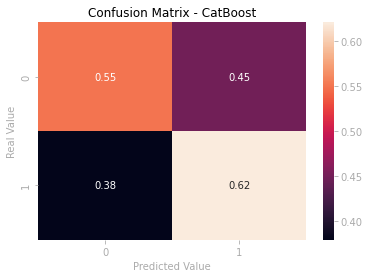

In [36]:
# final CatBoost model
cb = CatBoostClassifier(learning_rate=0.03, depth=6, l2_leaf_reg=10, logging_level='Silent')
cb.fit(X_train_rus, y_train_rus)

# prediction
X_test_cb = scaler.transform(X_test)
y_pred_cb = cb.predict(X_test_cb)

# classification report
print(classification_report(y_test, y_pred_cb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_cb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - CatBoost')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

## Conclusion

The main objective of this article was to build a machine learning algorithm that would be able to identify potential defaulters and therefore reduce company loss. The best model possible would be the one that could minimize false negatives, identifying all defaulters among the client base, while also minimizing false positives, preventing clients to be wrongly classified as defaulters.

Meeting these requirements can be quite tricky as there is a tradeoff between precision and recall, meaning that increasing the value of one of these metrics often decreases the value of the other. Considering the importance of minimizing company loss, we decided to give more emphasis on reducing false positives, searching for the best hyperparameters that could increase the recall rate.

Among the three **Gradient Boosting Algorithms** tested, **XGBoost** yielded the best results, with a recall rate of 81%, although it delivered an undesired 56% of false positives. On the other hand, **LightGBM** and **CatBoost** delivered a better count of false positives, with 38% and 33% respectively, but their false negatives were substantially higher than that of XGBoost, resulting in a weaker recall rate.

This article presents a classic evaluation metrics dilemma. In this case, it would be up to the company's decision-makers to analyze the big picture, with the aid of the machine learning algorithms, and decide the best plan to follow. Of course, in a future article, we can test a different approach to achieve a more desirable result, such as taking advantage of deep learning models.